# Libraries Required

In [1]:
import pandas as pd
import torch
from matplotlib import pyplot as plt
import spacy
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence,pad_packed_sequence
import re
import random
from collections import defaultdict
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from copy import deepcopy
from sklearn.metrics import confusion_matrix
import seaborn as sns


d:\Anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# set torch seeed

In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

# Set the seed
seed = 42  # You can use any integer value
set_seed(seed)

### Splitting the train.json to Train and Val
> #### For performing evaluation of the model.
> #### Performing Hyperparameter Search

In [4]:
#### read the train.json
train_val=pd.read_json('./data//subtask_1-train.jsonl',lines=True)
### read the test.json
test_data=pd.read_json('./data/subtask_1-test.jsonl',lines=True)
### split the dataset into 90/20 split
train_val

,sentence-id,text,choices,labels
0,0,CONTRORDINE COMPAGNI.\nFATE GIRARE LA VOCE CHE...,"[Contro, Favore, Neutrale]",0
1,1,A proposito dell'incontro delle @6000sardine c...,"[Contro, Favore, Neutrale]",2
2,2,Care sardine che richiamate in continuazione i...,"[Contro, Favore, Neutrale]",0
3,3,"Domanda ad una sardina "" secondo te Qual è il ...","[Contro, Favore, Neutrale]",0
4,4,A salvini non gli frega nulla delle sardine no...,"[Contro, Favore, Neutrale]",2
...,...,...,...,...
2127,2127,"Pidini non montatevi la testa, non avete perso...","[Contro, Favore, Neutrale]",2
2128,2128,Volete sapere perché il pd nonostante tutto di...,"[Contro, Favore, Neutrale]",2
2129,2129,#Omnibusla7 Telese in piena fregola per il cap...,"[Contro, Favore, Neutrale]",2
2130,2130,Noto con piacere che le librerie si stanno rip...,"[Contro, Favore, Neutrale]",2


In [5]:


def custom_train_val_split(data, test_size=0.1):
    """
    Custom train/validation split function without using scikit-learn.
    """
    # Shuffle the DataFrame to ensure randomness
    data_shuffled = data.sample(frac=1, random_state=42)

    # Group the DataFrame by the label column
    grouped = data_shuffled.groupby('labels')

    # Initialize empty DataFrames for train and validation sets
    train_data = pd.DataFrame()
    val_data = pd.DataFrame()

    # For each group, split the data into train and validation sets
    for label, group in grouped:
        # Calculate the number of samples for validation set
        num_val_samples = int(len(group) * test_size)

        # Select samples for validation set
        val_group = group.iloc[:num_val_samples]

        # Select remaining samples for train set
        train_group = group.iloc[num_val_samples:]

        # Concatenate the train and validation sets
        train_data = pd.concat([train_data, train_group])
        val_data = pd.concat([val_data, val_group])

    # Reset index for the new DataFrames
    train_data.reset_index(drop=True, inplace=True)
    train_data=train_data.sample(frac=1,random_state=420)
    val_data.reset_index(drop=True, inplace=True)
    val_data=val_data.sample(frac=1,random_state=420)

    return train_data, val_data

### get the splits
train_data, val_data = custom_train_val_split(train_val, test_size=0.2)
del train_val

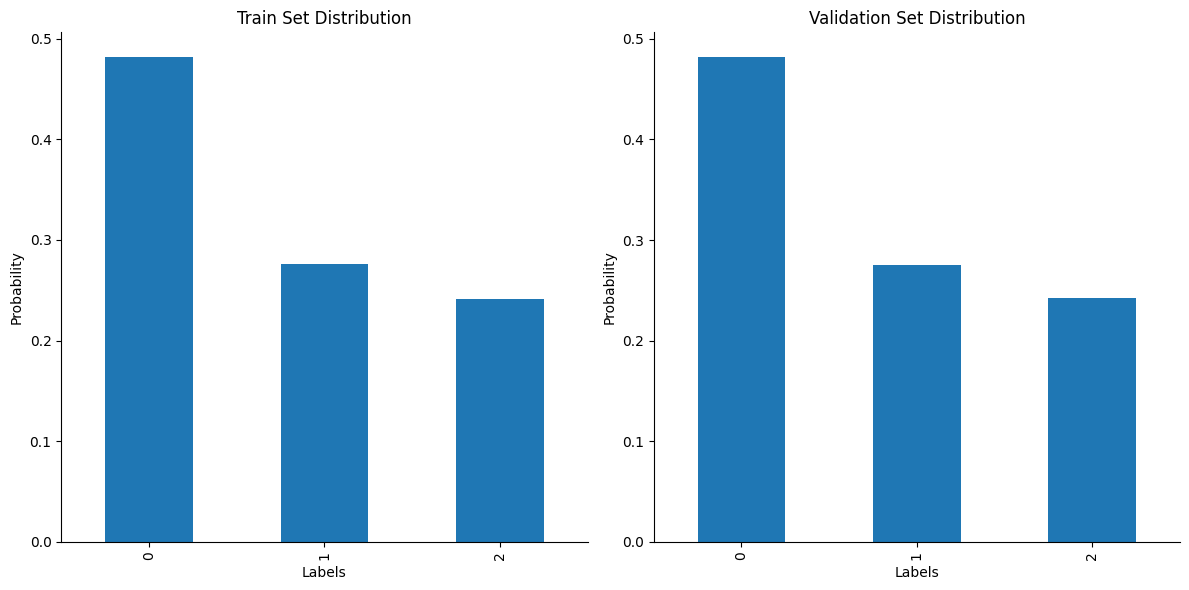

In [9]:
def plot_dist_labels(data: pd.DataFrame, ax, title: str):
    """
    Function to plot the distribution of the classes in a given dataframe
    """
    label_counts = data['labels'].value_counts(normalize=True)
    label_counts.plot(kind='bar', title=title, ax=ax)
    ax.set_xlabel('Labels')
    ax.set_ylabel('Probability')
    ax.spines[['top', 'right']].set_visible(False)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot class distribution for train set
plot_dist_labels(train_data, axs[0], title='Train Set Distribution')

# Plot class distribution for validation set
plot_dist_labels(val_data, axs[1], title='Validation Set Distribution')

# Adjust layout
plt.tight_layout()
plt.show()


> #### It's a choice that I made to implement a function for stratified spliiting instead of using sklearn train_test_split function for stratified sampling.
> #### We can clearly see the distribution among the classes are maintained during the split from the above plots

# Tokenisation,Vocab,Embedding -Spacy Lib

> #### 1. using it_core_news_lg(large) based model[https://spacy.io/models/it#it_core_news_lg] with 300dim of vectors


In [10]:
### get it_core_news_lg

!python -m spacy download it_core_news_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 567.9/567.9 MB 2.9 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_lg')


### Spacy Model
> #### Get the vocabualary and the vectors

In [11]:
nlp_ = spacy.load("it_core_news_lg")
#Get the vocabulary from the loaded italian spaCy model
words_list = list(nlp_.vocab.strings)
### get the vectors for the vocab words
vectors = [nlp_.vocab.get_vector(word) for word in words_list]

# Convert the list of vectors into a numpy array[Usage to intialiase embedding layer]
embeddings = np.array(vectors)
### remove redundant variables from memmory
del vectors
# Final Check
print("Number of words:{},Shape of embeddings:{}".format(len(words_list),embeddings.shape))

Number of words:681834,Shape of embeddings:(681834, 300)


> #### Add the vectors for pad and unk token

In [12]:
pad_vec=np.random.normal(size=(1,embeddings.shape[1]))
unk_vec=np.random.normal(size=(1,embeddings.shape[1]))
embeddings=np.concatenate((pad_vec,unk_vec,embeddings),axis=0)

# Character Dictiionary-Vocabulary for Character Based Embedding 

In [13]:
###character dict
char_list=list(
            """ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyzàèéìíîòóùûüÀÈÉÌÍÎÒÓÙÛÜ0123456789,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]"""
)
char_dict=defaultdict()

char_dict['<pad>']=0
char_dict['<unk>']=1

for i,j in enumerate(char_list):

    char_dict[j]=i+2

# Create Vocabulary Class


In [14]:

class Vocabulary:

    def __init__(self,vocab_):

        ### From index getting the token
        self.itos={}
        ### From token to Index
        self.stoi={}
        ### Size of the vocabulary
        self.size=len(vocab_)
        ### Storing the vocabulary
        self.vocab=vocab_

        ### padding token
        self.pad_token='<pad>'
        ### pre-trained embeddings[used in the spacy model] already handle the case of the unknown token via 'oov' token
#         #### unknown token
        self.unk_token='<unk>'

        #### stop words
        self.stop_words=nlp_.Defaults.stop_words
        
        ### embeddings
        self.embedding=None


    def indexed_vocab(self):
        """""
        Building Index Dictionay of words Position in the vocbulary.This would help in fast retrieval of vectorial representation of
        the words( and vice-versa)
        """""
        ### First adding info regarding <pad>  token
        self.itos[0]='<pad>'
        self.itos[1]='<unk>'

        self.stoi['<pad>']=0
        self.stoi['<unk>']=1

        #### iterate over vocab now
        for i,j in enumerate(self.vocab):

            ## Index to string
            self.itos[i+2]=j

            ## String to Index
            self.stoi[j]=i+2

   

vocab_it=Vocabulary(words_list)
### index the vocabulary
vocab_it.indexed_vocab()
### now i can remove the list of the words
del words_list



# Parts-of-Speech tag Vocabulary

In [15]:
class VocabPos:
    def __init__(self, pos_tags):
        # Store POS tags
        self.pos_tags = pos_tags
        # Initialize index dictionaries
        self.itos = {}
        self.stoi = {}
        # Build index dictionaries
        self.index_pos()
        ### size of the pos tag
        self.size=len(self.itos)

    def index_pos(self):
        # Add special tokens to dictionaries
        self.itos[0] = '<pad>'
        self.itos[1] = '<unk>'
        self.stoi['<pad>'] = 0
        self.stoi['<unk>'] = 1
        # Index POS tags
        for i, pos_tag in enumerate(self.pos_tags):
            self.itos[i + 2] = pos_tag
            self.stoi[pos_tag] = i + 2
            
all_pos_tags = [
    'ADJ', 'ADP', 'ADV', 'AUX', 'CONJ', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM',
    'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X'
]

# Create a VocabPos instance
pos_vocab = VocabPos(all_pos_tags)



# Custom Dataset

> #### Usage of collate function to handle non-equal length of text

In [16]:
class SST2Dataset(Dataset):
    def __init__(
        self,
        input_df: pd.DataFrame,
        max_length: int = 1028,
        device: str = "cuda"
    ):
        

        # Save samples from input file
        self.data = input_df.loc[:,['sentence-id','text','labels']]
        

        # Initialize indexed data attribute but leave it None
        # Must be filled through the `.index(vocabulary, label_vocabulary)` method
        # each dictionary represents a sentence with two keys: "input_ids" and "label"
        self.indexed_data: list[dict] | None = None

        # Keep track of the maximum length to allow for a batch
        self.max_length = max_length

        # Save device
        self.device = torch.device(device)

        # intialiase the padding id
        self.padding_id=0
        # Initialize POS vocabulary
        self.pos_vocab = None


    def get_raw_element(self, idx: int) -> dict:
        """Utility function that gets the raw sample corresponding to `idx`."""
        return self.data.iloc[idx].to_dict()

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> dict:
        if self.indexed_data is None:
            raise RuntimeError(
                "Trying to retrieve samples but dataset has not been indexed yet!"
                + " Be sure to call `.index()` on this object."
                + " If you want to retrieve raw elements, call `.get_raw_elements(idx)"
            )
        return self.indexed_data[idx]
    def remove_special_chars(self,text):
        # Define the regex pattern to match punctuations, special symbols, and numbers
        pattern = r'[\W\d_]+'
        # Substitute the pattern with an empty string
        cleaned_text = re.sub(pattern, ' ', text)
        return cleaned_text
    
    def preprocess_tokenise(self,text:str):
        """""
        this function preprocess and converts the string into list of tokens
        
        """""
        ####  process the text
        text=self.remove_special_chars(text)
        t=nlp_(text)
        ### remove the stop words and get the lemmas
        tokens_final=[i for i in t if i.text.lower() not in vocab_it.stop_words]
        ### get the pos tags
        pos_tags = [token.pos_ for token in tokens_final]
        return tokens_final, pos_tags

    def index(self, vocabulary: Vocabulary,pos_vocabulary:VocabPos) -> None:
        """Builds `self.indexed_data` by converting raw samples to input_ids following `vocabulary`"""
        if self.indexed_data is not None:
            print("Dataset has already been indexed. Keeping old index...")
        else:
            indexed_data = []
            self.pos_vocab=pos_vocabulary
            ### iterate over the dataset
            for i,sample in self.data.iterrows():
                
                #### Tokenisation of text 
                tokens,pos_tags=self.preprocess_tokenise(sample['text'])
                ### Tokens to ids
                token_ids=[vocabulary.stoi.get(j.lemma_.lower(),vocabulary.stoi['<unk>'])  for j in tokens]
                
                ###tokens to  pos tag indices
                pos_tag_indices = [self.pos_vocab.stoi.get(j, self.pos_vocab.stoi['<unk>']) for j in pos_tags]
               

                # append the dictionary containing ids of the input tokens and label
                indexed_data.append({"input_ids":token_ids,"pos_tags":pos_tag_indices, "labels": sample["labels"]})
            self.indexed_data = indexed_data
    
    def handle_unk(self,j,vocabulary):
        """
        Hanld unk case
        """
        ### if lemma form embedding is not found in the vocabulary,first check if there is vector in original form otherwise return 'oov' embedding (zero vec)
        
        
        return vocabulary.stoi.get(j.text.lower(),vocabulary.stoi['<unk>'])
    
    def _collate_fn(self,raw_batch: list[dict]) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Batches together single elements of the dataset.
        This function:
        - converts each sentence made up of single input_ids to a padded tensor,
        - keeps track of the length of each sentence through `sequence_lengths`
        - builds a `labels` tensor storing the label for each sentence

        Args:
            raw_batch (list[dict]): a list of elements, as returned by the `__getitem__()` function.

        Returns:
            A tuple of three tensors, respectively `(sequence_lengths, padded_sequence, labels)`
        """
        if self.padding_id is None:
            raise RuntimeError("Padding value not set! Set it through .set_padding_id method.")

        # We need these sequence lengths to construct a `torch.nn.utils.rnn.PackedSequence` in the model
        sequence_lengths = torch.tensor([len(sample["input_ids"]) for sample in raw_batch], dtype=torch.long)
        ### padding the seq's to common length
        padded_sequence = pad_sequence(
            (
                torch.tensor(sample["input_ids"], dtype=torch.long, device=self.device)
                for sample in raw_batch
            ),
            batch_first=True,
            padding_value=self.padding_id
        )
        ### getting the tensor array of labels for the batch
        labels = torch.tensor([sample["labels"] for sample in raw_batch], device=self.device, dtype=torch.long)
        
        
        # Pad POS tag indices
        padded_pos_tags = pad_sequence(
            (
                torch.tensor(sample["pos_tags"], dtype=torch.long, device=self.device)
                for sample in raw_batch
            ),
            batch_first=True,
            padding_value=self.padding_id
        )
        
        return sequence_lengths, padded_sequence, labels,padded_pos_tags
        

#### create training dataset
train_dataset=SST2Dataset(train_data)
### indexing 
train_dataset.index(vocab_it,pos_vocab)
#### create validation dataset
val_dataset=SST2Dataset(val_data)
### indexing 
val_dataset.index(vocab_it,pos_vocab)

#### create test dataset
test_dataset=SST2Dataset(test_data)
##indexing
test_dataset.index(vocab_it,pos_vocab)


In [17]:
#### create train/val/test dataloader
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=train_dataset._collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False, collate_fn=val_dataset._collate_fn
                           )
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, collate_fn=test_dataset._collate_fn
                           )

# Main Model

In [20]:
#### Model-1 Fixed Embedding[static+BILSTM+Projection layer]
class model_v1(torch.nn.Module):

    def __init__(
        self,
        vocabulary: Vocabulary,
        embeddings:np.array,
        hidden_dim_lstm_fac: int,
        bilstm_layers: int,
        dropout: float,
        num_classes: int,
        padding_id: int,
        freeze_embedding:bool,
        char_embed_bool:bool,
        char_embed_dim:int,
        char_kernel_size:int,
        cnn_lstm_bool:bool,
        average_tokens:bool,
        char_dict:dict,
        pos_vocab: VocabPos, 
        pos_embed_dim: int,  
        pos_embed_bool: bool,
        recurrent_type:str,
        device: str = "cuda",
    ) -> None:
        super().__init__()

        # Prepare the device
        self.device = torch.device(device)
        
        #### vocabulary
        self.vocab=vocabulary

        # Embedding layer
        self.embedding = nn.Embedding(
            num_embeddings=vocabulary.size+2,
            embedding_dim=embeddings.shape[1],
            padding_idx=padding_id, # avoid updating the gradient of padding entries
            device=self.device
        )
         #Load weights from the NumPy array
        self.embedding.weight.data.copy_(torch.from_numpy(embeddings))
        if freeze_embedding:
            self.embedding.weight.requires_grad=False
       
        
        ### Use characeter based embedding
        self.char_embed_bool=char_embed_bool
        if self.char_embed_bool:
            self.char_dict=char_dict
            ### character based embedding size
            self.char_embed_dim=char_embed_dim
            self.embedding_1=nn.Embedding(len(char_dict),self.char_embed_dim,device=self.device)
            ### word embedding using charcter embeddings. Using same dim as character embedding
            self.word_char_emb=char_embed_dim
            self.char_kernel_size=char_kernel_size
            self.cnn=nn.Conv2d(in_channels=1, out_channels=self.word_char_emb, kernel_size=(char_kernel_size, self.char_embed_dim), padding=(0,0),device=self.device)
        else:
            self.word_char_emb=0
            
        #POS tag embedding layer
        self.pos_embed_bool = pos_embed_bool
        if pos_embed_bool:
            self.pos_embed_dim=pos_embed_dim
            self.embedding_2 = nn.Embedding(
                num_embeddings=pos_vocab.size,
                embedding_dim=pos_embed_dim,
                padding_idx=padding_id,
                device=self.device
            )
        else:
            self.pos_embed_dim=0
        
        ### dropout layer
        self.drop_1=nn.Dropout(p=dropout)
        self.drop_2=nn.Dropout(p=dropout)
        
        # Recurrent layer type
        self.recurrent_type=recurrent_type
        if recurrent_type=='rnn':
            rec=nn.RNN
        elif recurrent_type=='gru':
            rec=nn.GRU
        else:
            rec=nn.LSTM
        ### intialise recrruent
        self.hidden_dim_lstm_fac=hidden_dim_lstm_fac
        if hidden_dim_lstm_fac==1:
            self.reduction=None
            self.rec = rec(
                input_size=embeddings.shape[1]+self.word_char_emb+self.pos_embed_dim,
                hidden_size=embeddings.shape[1]+self.word_char_emb+self.pos_embed_dim,
                num_layers=bilstm_layers,
                batch_first=True,
                dropout=dropout,
                bidirectional=True,
                device=self.device
            )
            
        else:
            self.reduction=nn.Linear(embeddings.shape[1]+self.word_char_emb+self.pos_embed_dim,int(hidden_dim_lstm_fac*(embeddings.shape[1]+self.word_char_emb+self.pos_embed_dim)),device=self.device)
            self.rec = rec(
                input_size=int(hidden_dim_lstm_fac*(embeddings.shape[1]+self.word_char_emb+self.pos_embed_dim)),
                hidden_size=int(hidden_dim_lstm_fac*(embeddings.shape[1]+self.word_char_emb+self.pos_embed_dim)),
                num_layers=bilstm_layers,
                batch_first=True,
                dropout=dropout,
                bidirectional=True,
                device=self.device
            )
            
         ### 1D CNN
        self.cnn_lstm_bool=cnn_lstm_bool
        if cnn_lstm_bool:
            self.cnn_lstm_out=nn.Sequential(*[nn.Conv1d(in_channels=1,out_channels=6,kernel_size=3,stride=2,device=self.device),nn.ReLU()])

        # Projection layer
        self.projection = nn.LazyLinear(
            out_features=num_classes,
            device=self.device
        )

        ### average over tokens check
        self.average_tokens=average_tokens

    def forward(self, batch) -> torch.Tensor:
        # Get the different parts of the batch
        sequence_lengths,input_ids,pos_tag_ids = batch
        
        # First we embed the input tokens (spacy model)
        embeds = self.embedding(input_ids) # [B, S, H]
        # where B is the batch size, S is the sequence length and H is the hidden dimension
        
        ### POS embedding
        if self.pos_embed_bool:
            pos_tag_embeddings = self.embedding_2(pos_tag_ids)
            embeds = torch.cat((embeds, pos_tag_embeddings), dim=-1)  # Concatenate POS tag embeddings
            
        if self.char_embed_bool:
            ### character embedding:
            embeds_1=self.char_embedding(self.vocab,self.char_embed_dim, input_ids)

            ### concantenate static + char embedding
            
            embeds=torch.cat((embeds,embeds_1),dim=2)
        
            
        ### DO dropout
        embeds-self.drop_1(embeds)
        
        

        
        # An alternative to packing sequences is using masking.
        
        
        if self.hidden_dim_lstm_fac==1:
            # Pack the sequence to avoid gradient descent on padding tokens.
            packed = pack_padded_sequence(embeds, sequence_lengths, batch_first=True, enforce_sorted=False)

            
            
            
            #### if recurrent layer is rnn or gru type
            if self.recurrent_type=='rnn' or self.recurrent_type=='gru':
                packed_output, hidden_state = self.rec(packed)
            
       
            else:
            ### if recurrent layyer is lstm type
                packed_output, (hidden_state, cell_state) = self.rec(packed)
            
        else:
            embeds=self.reduction(embeds)
            packed = pack_padded_sequence(embeds, sequence_lengths, batch_first=True, enforce_sorted=False)

            #### if recurrent layer is rnn or gru type
            if self.recurrent_type=='rnn' or self.recurrent_type=='gru':
                packed_output, hidden_state = self.rec(packed)
            
            #### if recurrent layyer is lstm type
            else:
                packed_output, (hidden_state, cell_state) = self.rec(packed)
        

        
        
        #### for the case sentence representation is computed using average of the tokens represenatation
        if self.average_tokens:
            sequence_lengths=sequence_lengths.to(self.device)
            ### create mask for pad tokens
            output=pad_packed_sequence(packed_output,batch_first=True)[0]
           
            mask = (torch.arange( output.size(1), device= output.device).expand( output.size(0),output.size(1)) < sequence_lengths.unsqueeze(1)).unsqueeze(2).repeat(1,1,output.shape[-1])
            
            ## sum over valid token
            sum_output=torch.sum(output*mask,dim=1)

            
            ### take average along tokens
            
            hidden=sum_output/sequence_lengths.unsqueeze(1)  ###[B,H]

        else:
            # We take the last two hidden representations of the BiLSTM (the second-to-last layer's output is forward; last
            # layer's is backward) by concatenating forward and backward over dimension 1.
            # Both tensors have shapes of [B, H], so concatenating them along the second dimension (dim 1) results in a new
            # tensor of shape [B, 2 * H]
            hidden = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim = 1)
        ### apply dropout
        hidden=self.drop_2(hidden)
        ### pass thorugh 1D CNN
        if self.cnn_lstm_bool:
            hidden=self.cnn_lstm_out(hidden.unsqueeze(1))
            hidden=hidden.reshape(hidden.shape[0],-1)


        # Finally we project to the two final classes and return the logits of each class
        
        logits = self.projection(hidden) # [B, 2]
        return logits
    
    def char_embedding(self,vocab:Vocabulary,chr_emb_dim,sentences:torch.tensor):
        
        ### assuming max length of a token
        max_length=40
        ## Intialising character-level index matrix [Batch_size, Max_padded sequence length] ==>[Batch_size, Max_padded sequence length,
        # Max_length]
        word_char=torch.zeros((sentences.size(0),sentences.size(1),max_length))
        ###iterating over the batches
        for i in range(sentences.size(0)):
            ### iterating over the tokens in a sentence
            for j in range(sentences.size(1)):

                word=self.vocab.itos[int(sentences[i,j])]

                if word != '<pad>' and word != '<unk>':
                    ###getting indexes of the character in each token
                    char_ix=[self.char_dict[k] for k in word if k in list(self.char_dict.keys())  ]
                    ### the word length should of max max_length

                    if len(char_ix) <=max_length:
                        word_char[i,j,0:len(char_ix)]=torch.LongTensor(char_ix)

                    ### if it is bigger i take the first max_legnth elements to get the index of the characters
                    else:
                        word_char[i,j,:]=torch.LongTensor(char_ix)[0:max_length]

        ### Intialiasing the character level embedding matrix [Batch_size, Max_padded sequence length,Charater-level-dimension]              
        word_emb=torch.zeros(word_char.size(0),word_char.size(1),self.char_embed_dim)

        ### iterating over the batches
        for i in range(word_char.size(0)):
            ### getting embedding for the sequence of tokens in the sentence using character-level embedding [Max_seq_length,max_length,
            # character-level-dimension]
            e=self.embedding_1(word_char[i].long().to(self.device))
            e=e.unsqueeze(1)
            ##Convolution

            con_e=self.cnn(e)

            ### max pool [Max_seq_length,character-level-dimension] for each sentence in batch
            
            word_emb[i]=nn.functional.max_pool2d(con_e,kernel_size=(con_e.size(2), 1)).view(con_e.size(0), self.word_char_emb)

        del(word_char)
        return(word_emb.to(self.device))

In [21]:
class Trainer():
    """Utility class to train and evaluate a model."""

    def __init__(
        self,
        model: nn.Module,
        optimizer: torch.optim.Optimizer,
        log_steps: int = 1_000,
        log_level: int = 2,
        patience: int = 4,  # Define the patience for early stopping
        use_best_weights:bool=False
    ):
        self.model = model
        self.optimizer = optimizer
        self.loss_function =nn.CrossEntropyLoss()
        self.log_steps = log_steps
        self.log_level = log_level
        
        
        ### early stopping
        self.patience = patience  # Store the patience value
        self.min_valid_loss = float('inf')  # Initialize the minimum validation loss
        self.best_train_loss = float('inf')  # Initialize the best training loss
        self.best_valid_acc = 0.0  # Initialize the best validation accuracy
        self.best_epoch = 0  # Initialize the epoch with the best validation loss
        self.num_bad_epochs = 0  # Counter for bad epochs
        
        ### save best weights
        self.use_best_weights=use_best_weights
        self.model_best_weights =None
        
    def train(
        self,
        train_dataloader: DataLoader,
        valid_dataloader: DataLoader,
        epochs: int = 1
    ) -> dict[str, list[float]]:
        """
        Args:
            train_dataloader: a DataLoader instance containing the training instances.
            valid_dataloader: a DataLoader instance used to evaluate learning progress.
            epochs: the number of times to iterate over train_dataset.

        Returns:
            avg_train_loss: the average training loss on train_dataset over epochs.
        """
        assert epochs >= 1 and isinstance(epochs, int)
        if self.log_level > 0:
            print('Training ...')
        train_loss = 0.0

        metrics = {
            "train_losses": [],
            "valid_losses": [],
            "valid_acc": [],
            'valid_f1':[],
            'valid_p':[],
            'valid_r':[]
        }

        for epoch in range(1, epochs + 1):


            epoch_loss = 0.0
            self.model.train()

            # for each batch
            for step, (sequence_lengths, inputs, labels,pos_tag_ids) in enumerate(train_dataloader):
                self.optimizer.zero_grad()

                # We get the predicted logits from the model, with no need to perform any flattening
                # as both predictions and labels refer to the whole sentence.
                predictions = self.model((sequence_lengths, inputs,pos_tag_ids))

                # The CrossEntropyLoss expects the predictions to be logits, i.e. non-softmaxed scores across
                sample_loss = self.loss_function(predictions, labels)
                ### loss backporp
                sample_loss.backward()
                self.optimizer.step()
                ###step loss
                epoch_loss += sample_loss.cpu().tolist()


            avg_epoch_loss = epoch_loss / len(train_dataloader)


            ### val metrics
            valid_loss, valid_acc, precision, recall, f1 = self.evaluate(valid_dataloader)
            ####Add results

            metrics["train_losses"].append(avg_epoch_loss)
            metrics["valid_losses"].append(valid_loss)
            metrics["valid_acc"].append(valid_acc)
            metrics['valid_f1'].append(f1)
            metrics['valid_p'].append(precision)
            metrics['valid_r'].append(recall)
            


            # Early stopping condition
            if valid_loss < self.min_valid_loss:
                self.min_valid_loss = valid_loss
                self.best_train_loss = avg_epoch_loss  # Update the best training loss
                self.best_valid_acc = valid_acc  # Update the best validation accuracy
                self.best_epoch = epoch  # Update the epoch with the best validation loss
                self.num_bad_epochs = 0  # Reset the counter if validation loss improves
                # Store the best model weights
                self.model_best_weights =deepcopy(self.model.state_dict())
            else:
                self.num_bad_epochs += 1

            if self.num_bad_epochs >= self.patience:
                print(f"Validation loss has not improved for {self.patience} epochs. Early stopping...")
                break  # Stop training if early stopping condition is met

        # Print the final best validation loss and corresponding training loss and validation accuracy
        print(f"Best validation loss: {self.min_valid_loss}")
        print(f"Train loss at best validation: {self.best_train_loss}")
        print(f"Validation accuracy at best validation: {self.best_valid_acc}")


        if self.log_level > 0:
            print('... Done!')

        return metrics,self.best_epoch


    def _compute_acc(self, logits: torch.Tensor, labels: torch.Tensor) -> float:
        #compute prediction based on highest prob 
        predictions = torch.argmax(logits, dim=1)

        return torch.mean((predictions == labels).float()).tolist() # type: ignore

    def evaluate(self, valid_dataloader: DataLoader,use_best_weights:bool=False) -> tuple[float, float]:
        """
        Args:
            valid_dataloader: the DataLoader to use to evaluate the model.
            use_best_weights:if the trainer should use the best weights

        Returns:
            avg_valid_loss: the average validation loss over valid_dataloader.
        """
        valid_loss = 0.0
        valid_acc = 0.0
        y_true = []
        y_pred = []
        
        ### check for uasge of best weights
        self.use_best_weights=use_best_weights
        if self.use_best_weights and self.model_best_weights is not None:
                # Load the best model weights
                print('Loading best weights')
                self.model.load_state_dict(self.model_best_weights)
        
        ### eval mode
        self.model.eval()
        with torch.no_grad():
            
            for batch in valid_dataloader:
                sequence_lengths, inputs, labels,pos_tag_ids = batch
                
                logits = self.model((sequence_lengths, inputs,pos_tag_ids))
        
                # Same considerations as the training step apply here
                sample_loss = self.loss_function(logits, labels)
                valid_loss += sample_loss.tolist()
        
                sample_acc = self._compute_acc(logits, labels)
                valid_acc += sample_acc

                # Convert logits to predictions
                predictions = torch.argmax(logits, dim=1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predictions.cpu().numpy())

        # Compute precision, recall, and F1 score
        precision = precision_score(y_true, y_pred, average='macro')
        recall = recall_score(y_true, y_pred, average='macro')
        f1 = f1_score(y_true, y_pred, average='macro')

        return valid_loss / len(valid_dataloader), valid_acc / len(valid_dataloader), precision, recall, f1

    def predict(self, batch: tuple[torch.Tensor, torch.Tensor]) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Args:
            x: a tensor of indices
        Returns:
            A tuple composed of:
            - the logits of each class, 0 and 1
            - the prediction for each sample in the batch
              0 if the sentiment of the sentence is negative, 1 if it is positive.
        """
        self.model.eval()
        with torch.no_grad():
            sequence_lengths, inputs = batch
            logits = self.model(sequence_lengths, inputs) # [B, 2]
            predictions = torch.argmax(logits, -1) # [B, 1] computed on the last dimension of the logits tensor
            return logits, predictions

> ### Note: Hyper Param Search
> #### The code is bit messy for the search but it's optimised for performance.I make sure no two iterations are redundant

In [8]:
def Hyper_param_search():
    """
    Perform Hyperparameter search for main model.
    
    """
    
    ### use char_emb
    char_emb_space=[True,False]
    
    ### char_embedding_dim soace
    char_emb_dim_space=[30,50]
    
    ### character kernel size
    char_kernel_size_space=[2,5]
    
    ### pos tag_emb
    pos_emb_space=[True,False]
    ## pos tag embedding size
    pos_emb_dim_space=[30,50]
    
    #### dropout
    dropout_space=[0.3,0.5]
    
    #### rec layer type
    rec_space=['rnn','gru','lstm']
    
    #### lr 
    lr_space=[1e-3,1e-4]
    
    ### weight decay
    weight_decay_space=[1e-4,1e-3]
    
    ### average tokens
    average_tokens_space=[True,False]
    
    #### 1D CNN at rec output
    cnn_lstm_space=[True,False]
    
    #### epochs
    max_epochs=50
    

    current_iteration = 0
    
    
    results=pd.DataFrame(columns=['param_space','metrics','best_epoch'])
#     results=pd.read_csv('/kaggle/input/hyper-param-intermediate-results/hyper_param_search_updated_inter.csv')
    
    for char_emb in char_emb_space:
        if char_emb:     
            for char_emb_dim in char_emb_dim_space:
                    for char_kernel_size in char_kernel_size_space:
                        for pos_emb in pos_emb_space:
                            ### if pos embedding being used
                            
                                if pos_emb:
                                    for pos_emb_dim in pos_emb_dim_space:
                                        for dropout in dropout_space:
                                            for rec_layer_type in rec_space:
                                                for lr in lr_space:
                                                    for weight_decay in weight_decay_space:
                                                        for average_tokens in average_tokens_space:
                                                            for cnn_lstm in cnn_lstm_space:
                                                                current_iteration += 1
                                                                set_seed(seed)
                                                                print(f"Iteration {current_iteration}")
                                                                # Perform hyperparameter search here
                                                                # Construct the configuration and train the model
                                                                config = {
                                                                    "char_emb": char_emb,
                                                                    "char_emb_dim": char_emb_dim,
                                                                    "char_kernel_size": char_kernel_size,
                                                                    "pos_emb": pos_emb,
                                                                    "pos_emb_dim": pos_emb_dim,
                                                                    "dropout": dropout,
                                                                    "rec_layer_type": rec_layer_type,
                                                                    "lr": lr,
                                                                    "weight_decay": weight_decay,
                                                                    "average_tokens": average_tokens,
                                                                    "cnn_lstm": cnn_lstm
                                                                }
                                                                
                                                                if str(config) not in list(results.param_space.values):
                                                                    ####  perform one iteration of search
                                                                    print("Current model configuration and params:", config)

                                                                    torch.cuda.empty_cache()

                                                                    sentiment_tagger =model_v1(
                                                                        vocab_it,
                                                                        embeddings,
                                                                        hidden_dim_lstm_fac=1,
                                                                        bilstm_layers=2,
                                                                        dropout=dropout,
                                                                        num_classes=3,
                                                                        padding_id=0,
                                                                        freeze_embedding=True,
                                                                        char_embed_dim=char_emb_dim,
                                                                        char_embed_bool=char_emb,
                                                                        char_kernel_size=char_kernel_size,
                                                                        cnn_lstm_bool=cnn_lstm,
                                                                        average_tokens=average_tokens,
                                                                        char_dict=char_dict,
                                                                    pos_vocab=pos_vocab,
                                                                    pos_embed_dim=pos_emb_dim,
                                                                    pos_embed_bool=pos_emb,
                                                                    recurrent_type=rec_layer_type)



                                                                    ### setup trainer
                                                                    trainer = Trainer(
                                                                        model=sentiment_tagger,
                                                                        optimizer=torch.optim.Adam(filter(lambda p: p.requires_grad,sentiment_tagger.parameters()), lr=lr,weight_decay=weight_decay),
                                                                        log_steps=100,patience=4
                                                                    )
                                                                    ###metrics
                                                                    metrics,best_epoch = trainer.train(train_dataloader, val_dataloader, epochs=max_epochs)
                                                                    #### 
                                                                    print('precision:{},recall:{},f1_score:{}'.format(metrics['valid_p'][best_epoch],metrics['valid_r'][best_epoch],metrics['valid_f1'][best_epoch]))
                                                                    results.loc[len(results)]=[config,metrics,best_epoch]
                                                                    results.to_csv('./data/hyper_param_search_main.csv',index=False)
                                else:
#                                         char_kernel_size=0
                                        
                                        pos_emb_dim=0
                                        for dropout in dropout_space:
                                                for rec_layer_type in rec_space:
                                                    for lr in lr_space:
                                                        for weight_decay in weight_decay_space:
                                                            for average_tokens in average_tokens_space:
                                                                for cnn_lstm in cnn_lstm_space:
                                                                    current_iteration += 1
                                                                    set_seed(seed)
                                                                    print(f"Iteration {current_iteration}")
                                                                    # Perform hyperparameter search here
                                                                    # Construct the configuration and train the model
                                                                    config = {
                                                                        "char_emb": char_emb,
                                                                        "char_emb_dim": char_emb_dim,
                                                                        "char_kernel_size": char_kernel_size,
                                                                        "pos_emb": pos_emb,
                                                                        "pos_emb_dim": pos_emb_dim,
                                                                        "dropout": dropout,
                                                                        "rec_layer_type": rec_layer_type,
                                                                        "lr": lr,
                                                                        "weight_decay": weight_decay,
                                                                        "average_tokens": average_tokens,
                                                                        "cnn_lstm": cnn_lstm
                                                                    }

                                                                    if str(config) not in list(results.param_space.values):
                                                                        ####  perform one iteration of search
                                                                        print("Current configuration:", config)
                                                                        torch.cuda.empty_cache()

                                                                        sentiment_tagger =model_v1(
                                                                            vocab_it,
                                                                            embeddings,
                                                                            hidden_dim_lstm_fac=1,
                                                                            bilstm_layers=2,
                                                                            dropout=dropout,
                                                                            num_classes=3,
                                                                            padding_id=0,
                                                                            freeze_embedding=True,
                                                                            char_embed_dim=char_emb_dim,
                                                                            char_embed_bool=char_emb,
                                                                            char_kernel_size=char_kernel_size,
                                                                            cnn_lstm_bool=cnn_lstm,
                                                                            average_tokens=average_tokens,
                                                                            char_dict=char_dict,
                                                                        pos_vocab=pos_vocab,
                                                                        pos_embed_dim=pos_emb_dim,
                                                                        pos_embed_bool=pos_emb,
                                                                        recurrent_type=rec_layer_type)



                                                                        ### setup trainer
                                                                        trainer = Trainer(
                                                                            model=sentiment_tagger,
                                                                            optimizer=torch.optim.Adam(filter(lambda p: p.requires_grad,sentiment_tagger.parameters()), lr=lr,weight_decay=weight_decay),
                                                                            log_steps=100,patience=4
                                                                        )
                                                                        ###metrics
                                                                        metrics,best_epoch = trainer.train(train_dataloader, val_dataloader, epochs=max_epochs)
                                                                        #### 
                                                                        print('precision:{},recall:{},f1_score:{}'.format(metrics['valid_p'][best_epoch],metrics['valid_r'][best_epoch],metrics['valid_f1'][best_epoch]))
                                                                        results.loc[len(results)]=[config,metrics,best_epoch]
                                                                        results.to_csv('./data/hyper_param_search_main.csv',index=False)

        else:
            char_emb_dim=0
            char_kernel_size=0
            for pos_emb in pos_emb_space:
                            ### if pos embedding being used
                            
                                if pos_emb:
                                    for pos_emb_dim in pos_emb_dim_space:
                                        for dropout in dropout_space:
                                            for rec_layer_type in rec_space:
                                                for lr in lr_space:
                                                    for weight_decay in weight_decay_space:
                                                        for average_tokens in average_tokens_space:
                                                            for cnn_lstm in cnn_lstm_space:
                                                                current_iteration += 1
                                                                set_seed(seed)
                                                                
                                                                print(f"Iteration {current_iteration}")
                                                                
                                                                
                                                                 # Construct the configuration and train the model
                                                                config = {
                                                                        "char_emb": char_emb,
                                                                        "char_emb_dim": char_emb_dim,
                                                                        "char_kernel_size": char_kernel_size,
                                                                        "pos_emb": pos_emb,
                                                                        "pos_emb_dim": pos_emb_dim,
                                                                        "dropout": dropout,
                                                                        "rec_layer_type": rec_layer_type,
                                                                        "lr": lr,
                                                                        "weight_decay": weight_decay,
                                                                        "average_tokens": average_tokens,
                                                                        "cnn_lstm": cnn_lstm
                                                                    }

                                                                if str(config)not in list(results.param_space.values):
                                                                    print("Current configuration:", config)
                                                                    ####  perform one iteration of search
                                                                    torch.cuda.empty_cache()

                                                                    sentiment_tagger =model_v1(
                                                                        vocab_it,
                                                                        embeddings,
                                                                        hidden_dim_lstm_fac=1,
                                                                        bilstm_layers=2,
                                                                        dropout=dropout,
                                                                        num_classes=3,
                                                                        padding_id=0,
                                                                        freeze_embedding=True,
                                                                        char_embed_dim=char_emb_dim,
                                                                        char_embed_bool=char_emb,
                                                                        char_kernel_size=char_kernel_size,
                                                                        cnn_lstm_bool=cnn_lstm,
                                                                        average_tokens=average_tokens,
                                                                        char_dict=char_dict,
                                                                    pos_vocab=pos_vocab,
                                                                    pos_embed_dim=pos_emb_dim,
                                                                    pos_embed_bool=pos_emb,
                                                                    recurrent_type=rec_layer_type)



                                                                    ### setup trainer
                                                                    trainer = Trainer(
                                                                        model=sentiment_tagger,
                                                                        optimizer=torch.optim.Adam(filter(lambda p: p.requires_grad,sentiment_tagger.parameters()), lr=lr,weight_decay=weight_decay),
                                                                        log_steps=100,patience=4
                                                                    )
                                                                    ###metrics
                                                                    metrics,best_epoch = trainer.train(train_dataloader, val_dataloader, epochs=max_epochs)
                                                                    #### 
                                                                    print('precision:{},recall:{},f1_score:{}'.format(metrics['valid_p'][best_epoch],metrics['valid_r'][best_epoch],metrics['valid_f1'][best_epoch]))
                                                                    results.loc[len(results)]=[config,metrics,best_epoch]
                                                                    results.to_csv('./data/hyper_param_search_main.csv',index=False)
                                else:
                                        pos_emb_dim=0
                                        for dropout in dropout_space:
                                                for rec_layer_type in rec_space:
                                                    for lr in lr_space:
                                                        for weight_decay in weight_decay_space:
                                                            for average_tokens in average_tokens_space:
                                                                for cnn_lstm in cnn_lstm_space:
                                                                    current_iteration += 1
                                                                    set_seed(seed)
                                                                    print(f"Iteration {current_iteration}")
                                                                    # Perform hyperparameter search here
                                                                    # Construct the configuration and train the model
                                                                    config = {
                                                                        "char_emb": char_emb,
                                                                        "char_emb_dim": char_emb_dim,
                                                                        "char_kernel_size": char_kernel_size,
                                                                        "pos_emb": pos_emb,
                                                                        "pos_emb_dim": pos_emb_dim,
                                                                        "dropout": dropout,
                                                                        "rec_layer_type": rec_layer_type,
                                                                        "lr": lr,
                                                                        "weight_decay": weight_decay,
                                                                        "average_tokens": average_tokens,
                                                                        "cnn_lstm": cnn_lstm
                                                                    }
                                                                    if str(config) not in list(results.param_space.values):
                                                                        ####  perform one iteration of search
                                                                        print("Current configuration:", config)
                                                                        torch.cuda.empty_cache()

                                                                        sentiment_tagger =model_v1(
                                                                            vocab_it,
                                                                            embeddings,
                                                                            hidden_dim_lstm_fac=1,
                                                                            bilstm_layers=2,
                                                                            dropout=dropout,
                                                                            num_classes=3,
                                                                            padding_id=0,
                                                                            freeze_embedding=True,
                                                                            char_embed_dim=char_emb_dim,
                                                                            char_embed_bool=char_emb,
                                                                            char_kernel_size=char_kernel_size,
                                                                            cnn_lstm_bool=cnn_lstm,
                                                                            average_tokens=average_tokens,
                                                                            char_dict=char_dict,
                                                                        pos_vocab=pos_vocab,
                                                                        pos_embed_dim=pos_emb_dim,
                                                                        pos_embed_bool=pos_emb,
                                                                        recurrent_type=rec_layer_type)



                                                                        ### setup trainer
                                                                        trainer = Trainer(
                                                                            model=sentiment_tagger,
                                                                            optimizer=torch.optim.Adam(filter(lambda p: p.requires_grad,sentiment_tagger.parameters()), lr=lr,weight_decay=weight_decay),
                                                                            log_steps=100,patience=4
                                                                        )
                                                                        ###metrics
                                                                        metrics,best_epoch = trainer.train(train_dataloader, val_dataloader, epochs=max_epochs)
                                                                        #### 
                                                                        print('precision:{},recall:{},f1_score:{}'.format(metrics['valid_p'][best_epoch],metrics['valid_r'][best_epoch],metrics['valid_f1'][best_epoch]))
                                                                        results.loc[len(results)]=[config,metrics,best_epoch]
                                                                        results.to_csv('./data/hyper_param_search_main.csv',index=False)

                                                
    
    
    
    
    

### Run Hyper param search for the main model

> #### Only run if you want to reporduce results as it would take around 20 hours for completion

In [74]:
# Hyper_param_search()

### Reading the stored results

In [6]:
df_main_hyper_results=pd.read_csv('./data/hyper_param_results_main.csv')
df_main_hyper_results

,param_space,metrics,best_epoch
0,"{'char_emb': True, 'char_emb_dim': 30, 'char_k...","{'train_losses': [1.0597900322505407, 0.984651...",3
1,"{'char_emb': True, 'char_emb_dim': 30, 'char_k...","{'train_losses': [1.1237637911524092, 0.976582...",3
2,"{'char_emb': True, 'char_emb_dim': 30, 'char_k...","{'train_losses': [1.075956608567919, 0.9492638...",2
3,"{'char_emb': True, 'char_emb_dim': 30, 'char_k...","{'train_losses': [1.1552448783602034, 0.898589...",1
4,"{'char_emb': True, 'char_emb_dim': 30, 'char_k...","{'train_losses': [1.0596617545400346, 0.987529...",3
...,...,...,...
1435,"{'char_emb': False, 'char_emb_dim': 0, 'char_k...","{'train_losses': [1.0702060801642281, 1.037001...",8
1436,"{'char_emb': False, 'char_emb_dim': 0, 'char_k...","{'train_losses': [1.0686750071389335, 1.046038...",12
1437,"{'char_emb': False, 'char_emb_dim': 0, 'char_k...","{'train_losses': [1.0700206415993827, 1.042821...",10
1438,"{'char_emb': False, 'char_emb_dim': 0, 'char_k...","{'train_losses': [1.068851547581809, 1.0435801...",13


# Selection of Hyper-param based on Validation Acc

In [25]:

df_main_hyper_results['val_acc']=df_main_hyper_results.apply(lambda x:eval(x.metrics)['valid_acc'][x.best_epoch-1],axis=1)
df_main_hyper_results['val_f1']=df_main_hyper_results.apply(lambda x:eval(x.metrics)['valid_f1'][x.best_epoch-1],axis=1)
df_main_hyper_results['val_loss']=df_main_hyper_results.apply(lambda x:eval(x.metrics)['valid_losses'][x.best_epoch-1],axis=1)
# Sort the DataFrame by val_acc in decreasing order
df_main_hyper_results = df_main_hyper_results.sort_values(by='val_acc', ascending=False)

# Display the sorted DataFrame
print('The best Hyperparameter combination is: ',df_main_hyper_results.iloc[0].param_space)
print('Validation acc achived by the selected combination of Hyperparameters: ',df_main_hyper_results.iloc[0].val_acc)
print('Validation loss achived by the selected combination of Hyperparameters: ',eval(df_main_hyper_results.iloc[0].metrics)['valid_losses'][df_main_hyper_results.iloc[0].best_epoch-1])
      

The best Hyperparameter combination is:  {'char_emb': True, 'char_emb_dim': 30, 'char_kernel_size': 5, 'pos_emb': False, 'pos_emb_dim': 0, 'dropout': 0.3, 'rec_layer_type': 'lstm', 'lr': 0.0001, 'weight_decay': 0.0001, 'average_tokens': True, 'cnn_lstm': False}
Validation acc achived by the selected combination of Hyperparameters:  0.5718845278024673
Validation loss achived by the selected combination of Hyperparameters:  1.000121369957924


# Top-6 configurations

In [40]:
keys=list(eval(df_main_hyper_results.iloc[0].param_space).keys())
keys+=list(eval(df_main_hyper_results.iloc[0].metrics).keys())
df_hyper_param_table_main=pd.DataFrame(columns=keys)
for _,j in df_main_hyper_results.iterrows():
    row=[i for k,i in enumerate(eval(j.param_space).values())]
    row+=[i[j.best_epoch-1] for v,i in enumerate(eval(j.metrics).values())]
    df_hyper_param_table_main.loc[len(df_hyper_param_table_main)]=row
df_hyper_param_table_main.head(6)

,char_emb,char_emb_dim,char_kernel_size,pos_emb,pos_emb_dim,dropout,rec_layer_type,lr,weight_decay,average_tokens,cnn_lstm,train_losses,valid_losses,valid_acc,valid_f1,valid_p,valid_r
0,True,30,5,False,0,0.3,lstm,0.0001,0.0001,True,False,0.818308,1.000121,0.571885,0.491523,0.534694,0.497053
1,True,50,5,False,0,0.5,lstm,0.0010,0.0010,True,True,0.919731,0.972899,0.570408,0.448133,0.573763,0.471597
2,False,0,0,True,50,0.3,rnn,0.0001,0.0010,True,True,0.834105,1.000253,0.566263,0.483951,0.549332,0.483134
3,True,30,2,False,0,0.3,gru,0.0001,0.0001,False,True,0.778053,0.995906,0.564548,0.441720,0.498993,0.464273
4,True,30,2,False,0,0.5,gru,0.0001,0.0001,True,True,0.860648,0.994787,0.564310,0.436012,0.569453,0.464305
5,True,50,2,False,0,0.5,lstm,0.0010,0.0001,False,False,0.835726,1.018561,0.562357,0.478181,0.537060,0.476600


# Re-train model with the best hyper-param

In [26]:
torch.cuda.empty_cache()  
set_seed(seed)
### best_config
config=eval(df_main_hyper_results.iloc[0].param_space)
### intialise the model
sentiment_tagger =model_v1(
                            vocab_it,
                            embeddings,
                            hidden_dim_lstm_fac=1,
                            bilstm_layers=2,
                            dropout=config['dropout'],
                            num_classes=3,
                            padding_id=0,
                            freeze_embedding=True,
                            char_embed_dim=config['char_emb_dim'],
                            char_embed_bool=config['char_emb'],
                            char_kernel_size=config['char_kernel_size'],
                            cnn_lstm_bool=config['cnn_lstm'],
                            average_tokens=config['average_tokens'],
                            char_dict=char_dict,
                        pos_vocab=pos_vocab,
                        pos_embed_dim=config['pos_emb_dim'],
                        pos_embed_bool=config['pos_emb'],
                        recurrent_type=config['rec_layer_type'])



### setup trainer
trainer_main = Trainer(
    model=sentiment_tagger,
    optimizer=torch.optim.Adam(filter(lambda p: p.requires_grad,sentiment_tagger.parameters()), lr=config['lr'],weight_decay=config['weight_decay']),
    log_steps=100,patience=4
)
###metrics
metrics,best_epoch = trainer_main.train(train_dataloader, val_dataloader, epochs=400)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Training ...


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Validation loss has not improved for 4 epochs. Early stopping...
Best validation loss: 1.000121369957924
Train loss at best validation: 0.8183079021317619
Validation accuracy at best validation: 0.5718845278024673
... Done!


# 

# Final Model Structure

In [27]:
print(trainer_main.model)

model_v1(
  (embedding): Embedding(681836, 300, padding_idx=0)
  (embedding_1): Embedding(116, 30)
  (cnn): Conv2d(1, 30, kernel_size=(5, 30), stride=(1, 1))
  (drop_1): Dropout(p=0.3, inplace=False)
  (drop_2): Dropout(p=0.3, inplace=False)
  (rec): LSTM(330, 330, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (projection): Linear(in_features=660, out_features=3, bias=True)
)


### Validation Set Performance

In [28]:
#### load best model and get the performance on validation set
metrics_val_main=trainer_main.evaluate(val_dataloader,True)
print('The results on the val data: test_loss:{},test_acc:{},precision:{},recall:{},f1_score:{}'.format(*metrics_val_main))

Loading best weights
The results on the val data: test_loss:1.000121369957924,test_acc:0.5718845278024673,precision:0.5346938898143724,recall:0.497052567239638,f1_score:0.4915225923702038


### Test set performance

In [29]:
metrics_test_main=trainer_main.evaluate(test_dataloader,True)
print('The results on the test data: test_loss:{},test_acc:{},precision:{},recall:{},f1_score:{}'.format(*metrics_test_main))

Loading best weights
The results on the test data: test_loss:0.8459055688646104,test_acc:0.6487806836764017,precision:0.5105711511223316,recall:0.48776838510744364,f1_score:0.4945147105489822


# Model-2- Static Embedding+NN

In [34]:
#### Model-1 Fixed Embedding[static+NN]
class model_simple(torch.nn.Module):

    def __init__(
        self,
        vocabulary: Vocabulary,
        embeddings:np.array,
        dropout: float,
        num_classes: int,
        padding_id: int,
        freeze_embedding:bool,
        add_linear:bool,
        linear_hid_fac:float,
        device: str = "cuda",
    ) -> None:
        super().__init__()

        # Prepare the device
        self.device = torch.device(device)
        
        #### vocabulary
        self.vocab=vocabulary

        # Embedding layer
        self.embedding = nn.Embedding(
            num_embeddings=vocabulary.size+2,
            embedding_dim=embeddings.shape[1],
            padding_idx=padding_id, # avoid updating the gradient of padding entries
            device=self.device
        )
         #Load weights from the NumPy array
        self.embedding.weight.data.copy_(torch.from_numpy(embeddings))
        if freeze_embedding:
            self.embedding.weight.requires_grad=False

        
        ### dropout layer
        self.drop_1=nn.Dropout(p=dropout)
        self.drop_2=nn.Dropout(p=dropout)
       
        #### Add linear layers
        self.add_linear=add_linear
        
        if self.add_linear:
            self.linear=nn.Sequential(*[nn.Linear(embeddings.shape[1],int(embeddings.shape[1]*linear_hid_fac),device=self.device),nn.ReLU()])
        # Projection layer
        self.projection = nn.LazyLinear(
            out_features=num_classes,
            device=self.device
        )

    def forward(self, batch) -> torch.Tensor:
        # Get the different parts of the batch
        sequence_lengths,input_ids,pos_tag_ids = batch
        
        # First we embed the input tokens (spacy model)
        embeds = self.embedding(input_ids) # [B, S, H]
        # where B is the batch size, S is the sequence length and H is the hidden dimension
       
        ### DO dropout
        output=self.drop_1(embeds)
        
        ### if non-linear before[Linear+RelU]
        
    
        
        
        #### for the getting the sentence representation we compute average of the tokens word_embedding
        sequence_lengths=sequence_lengths.to(self.device)
        ### create mask for pad tokens
        mask = (torch.arange( output.size(1), device= output.device).expand( output.size(0),output.size(1)) < sequence_lengths.unsqueeze(1)).unsqueeze(2).repeat(1,1,output.shape[-1])

        ## sum over valid token across tokens axis
        sum_output=torch.sum(output*mask,dim=1)
#             max_output=torch.max(output*mask,dim=1).values

        ### take average along tokens

        hidden=sum_output/sequence_lengths.unsqueeze(1)  ###[B,H]

        ### apply dropout
        hidden=self.drop_2(hidden)
        ### apply non linear layer
        if self.add_linear:
            output=self.linear(output)
        # Finally we project to the three final classes and return the logits of each class
        logits = self.projection(hidden) # [B, 2]
        return logits
    
    

In [10]:
def Hyper_param_search_simple():
    
    """
    Perform Hyperparameter search for simple model.
    
    """
    
    #### dropout
    dropout_space=[0.3,0.5]
    
   

    #### lr 
    lr_space=[1e-3,1e-4]
    
    ### weight decay
    weight_decay_space=[1e-4,1e-3]
    
    ### add linear
    add_linear_space=[True,False]
    
    ### linear output dim fac wrt to input
    linear_hid_fac_space=[0.5,1,1.5,2]
    
    
    results=pd.DataFrame(columns=['param_space','metrics','best_epoch'])
    for add_linear in add_linear_space:
        if add_linear==True:
            for linear_hid_fac in linear_hid_fac_space:
                for p in dropout_space:
                    for lr in lr_space:
                        for weight_decay in weight_decay_space:
                            config = {
                                        "dropout": p,
                                        "lr": lr,
                                        "weight_decay": weight_decay,
                                         'add_linear':add_linear,
                                         'linear_hid_fac':linear_hid_fac
                                        }
                            print("Current configuration:", config)
                            set_seed(seed)
                            torch.cuda.empty_cache()    
                            sentiment_tagger =model_simple(
                                                vocab_it,
                                                embeddings,
                                                dropout=p,
                                                num_classes=3,
                                                padding_id=0,
                                                freeze_embedding=True,
                                                add_linear=add_linear,
                                                linear_hid_fac=linear_hid_fac
                            )



                            ### setup trainer
                            trainer = Trainer(
                                model=sentiment_tagger,
                                optimizer=torch.optim.Adam(filter(lambda p: p.requires_grad,sentiment_tagger.parameters()), lr=1e-4,weight_decay=1e-4),
                                log_steps=100,patience=4
                            )
                            ###metrics
                            metrics,best_epoch = trainer.train(train_dataloader, val_dataloader, epochs=400)



                    print('precision:{},recall:{},f1_score:{}'.format(metrics['valid_p'][best_epoch],metrics['valid_r'][best_epoch],metrics['valid_f1'][best_epoch]))
                    results.loc[len(results)]=[config,metrics,best_epoch]
                    results.to_csv('./data/hyper_param_search_simple.csv',index=False)
        else:
                linear_hid_fac='None'
                for p in dropout_space:
                    for lr in lr_space:
                        for weight_decay in weight_decay_space:
                            set_seed(seed)
                            config = {
                                        "dropout": p,
                                        "lr": lr,
                                        "weight_decay": weight_decay,
                                         'add_linear':add_linear,
                                         'linear_hid_fac':linear_hid_fac
                                        }
                            print("Current configuration:", config)
                            torch.cuda.empty_cache()    
                            sentiment_tagger =model_simple(
                                                vocab_it,
                                                embeddings,
                                                dropout=p,
                                                num_classes=3,
                                                padding_id=0,
                                                freeze_embedding=True,
                                                add_linear=add_linear,
                                                linear_hid_fac=linear_hid_fac
                            )



                            ### setup trainer
                            trainer = Trainer(
                                model=sentiment_tagger,
                                optimizer=torch.optim.Adam(filter(lambda p: p.requires_grad,sentiment_tagger.parameters()), lr=1e-4,weight_decay=1e-4),
                                log_steps=100,patience=4
                            )
                            ###metrics
                            metrics,best_epoch = trainer.train(train_dataloader, val_dataloader, epochs=400)



                    print('precision:{},recall:{},f1_score:{}'.format(metrics['valid_p'][best_epoch],metrics['valid_r'][best_epoch],metrics['valid_f1'][best_epoch]))
                    results.loc[len(results)]=[config,metrics,best_epoch]
                    results.to_csv('/data/hyper_param_search_simple.csv',index=False)

    
    
    
    
    

# Run Hyper-param-search for Simpler model

> ### Quite fast

In [36]:
# Hyper_param_search_simple()

# 

# Selection of Hyper-param based on Validation Acc

In [9]:
df_results_simple=pd.read_csv('./data/hyper_param_search_simple.csv')
df_results_simple['val_acc']=df_results_simple.apply(lambda x:eval(x.metrics)['valid_acc'][x.best_epoch-1],axis=1)
df_results_simple['val_f1']=df_results_simple.apply(lambda x:eval(x.metrics)['valid_f1'][x.best_epoch-1],axis=1)

# Sort the DataFrame by val_acc in decreasing order
df_results_simple = df_results_simple.sort_values(by='val_acc', ascending=False)


print('The best Hyperparameter combination is: ',df_results_simple.iloc[0].param_space)
print('Validation acc achived by the selected combination of Hyperparameters: ',df_results_simple.iloc[0].val_acc)
print('Validation loss achived by the selected combination of Hyperparameters: ',eval(df_results_simple.iloc[0].metrics)['valid_losses'][df_results_simple.iloc[0].best_epoch-1])
 

The best Hyperparameter combination is:  {'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 0.001, 'add_linear': False, 'linear_hid_fac': 'None'}
Validation acc achived by the selected combination of Hyperparameters:  0.5372046381235123
Validation loss achived by the selected combination of Hyperparameters:  0.9980201423168182


### Top-6 Model configurations

In [38]:
keys = list(eval(df_results_simple.iloc[0].param_space).keys())
keys += list(eval(df_results_simple.iloc[0].metrics).keys())
df_hyper_param_table_simple = pd.DataFrame(columns=keys)

for _, j in df_results_simple.iterrows():
    row = [i for k, i in enumerate(eval(j.param_space).values())]
    row += [i[j.best_epoch - 1] for v, i in enumerate(eval(j.metrics).values())]
    df_hyper_param_table_simple.loc[len(df_hyper_param_table_simple)] = row

df_hyper_param_table_simple.head(6)


,dropout,lr,weight_decay,add_linear,linear_hid_fac,train_losses,valid_losses,valid_acc,valid_f1,valid_p,valid_r
0,0.3,0.0001,0.001,False,None,0.987682,0.998020,0.537205,0.369471,0.477315,0.407775
1,0.5,0.0001,0.001,True,0.5,1.015314,1.009075,0.527201,0.328412,0.534136,0.386224
2,0.5,0.0001,0.001,True,1.5,1.015314,1.009075,0.527201,0.328412,0.534136,0.386224
3,0.5,0.0001,0.001,True,1,1.015314,1.009075,0.527201,0.328412,0.534136,0.386224
4,0.5,0.0001,0.001,False,None,1.047423,1.010087,0.525486,0.318113,0.549777,0.378064
5,0.5,0.0001,0.001,True,2,1.018718,1.010378,0.515006,0.316398,0.518706,0.378467


# Re-train model with the best hyper-param

In [39]:
torch.cuda.empty_cache()  
set_seed(seed)
### best_config
config=eval(df_results_simple.iloc[0].param_space)
sentiment_tagger =model_simple(
                    vocab_it,
                    embeddings,
                    dropout=config['dropout'],
                    num_classes=3,
                    padding_id=0,
                    freeze_embedding=True,
                    add_linear=config['add_linear'],
                    linear_hid_fac=config['linear_hid_fac']
)




### setup trainer
trainer_simple = Trainer(
    model=sentiment_tagger,
    optimizer=torch.optim.Adam(filter(lambda p: p.requires_grad,sentiment_tagger.parameters()), lr=config['lr'],weight_decay=config['weight_decay']),
    log_steps=100,patience=4
)
###metrics
metrics,best_epoch = trainer_simple.train(train_dataloader, val_dataloader, epochs=400)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Training ...
Validation loss has not improved for 4 epochs. Early stopping...
Best validation loss: 0.9980262964963913
Train loss at best validation: 0.9876272976398468
Validation accuracy at best validation: 0.5372046381235123
... Done!


# Final Simple Model Structure


In [40]:
print(trainer_simple.model)

model_simple(
  (embedding): Embedding(681836, 300, padding_idx=0)
  (drop_1): Dropout(p=0.3, inplace=False)
  (drop_2): Dropout(p=0.3, inplace=False)
  (projection): Linear(in_features=300, out_features=3, bias=True)
)


### Validation Performance

In [41]:
#### load best model and get the performance on validation set
metrics_val_simple=trainer_simple.evaluate(val_dataloader,True)
print('The results on the val data: test_loss:{},test_acc:{},precision:{},recall:{},f1_score:{}'.format(*metrics_val_simple))

Loading best weights
The results on the val data: test_loss:0.9980262964963913,test_acc:0.5372046381235123,precision:0.4773145410342335,recall:0.4077750859659455,f1_score:0.36947070136945787


### Test Performance

In [50]:
metrics_test_simple=trainer_simple.evaluate(test_dataloader,True)
print('The results on the test data: test_loss:{},test_acc:{},precision:{},recall:{},f1_score:{}'.format(*metrics_test_simple))

Loading best weights
The results on the test data: test_loss:0.873625722196367,test_acc:0.6691093312369453,precision:0.5008966587476607,recall:0.4305138905057415,f1_score:0.43216027065200663


# Baseline Model-Stratified Sampling

In [42]:
#### Model-1 Fixed Embedding[static+BILSTM+Projection layer]
class model_baseline_stratified(torch.nn.Module):

    def __init__(
        self,
        class_weights:torch.tensor,
        device: str = "cuda",
    ) -> None:
        super().__init__()

        # Prepare the device
        self.device = torch.device(device)
        ### Class weights
        self.class_weights=class_weights
        self.class_weights.to(self.device)

    def forward(self, batch_size) -> torch.Tensor:
        #### BAsed on stratified sampliing
        #### 
        prob= torch.rand(batch_size)
        
        ### assign labels
        labels=torch.tensor([self.assign_class(i) for i in prob])
        
        return labels
    def assign_class(self,x):
        if x<class_weights[0]:
            return 0
        elif (x>class_weights[0]) and (x<class_weights[1]):
            return 1
        else:
            return 2
        
    
class Trainer_baseline():
     def __init__(
        self,
        model: nn.Module,
    ):
        self.model = model
        self.loss_function =nn.CrossEntropyLoss()
    
     def train(
        self,
        train_dataloader: DataLoader,
        valid_dataloader: DataLoader,
        epochs: int = 1
    ) -> dict[str, list[float]]:
        """
        Args:
            train_dataloader: a DataLoader instance containing the training instances.
            valid_dataloader: a DataLoader instance used to evaluate learning progress.
            epochs: the number of times to iterate over train_dataset.

        Returns:
            avg_train_loss: the average training loss on train_dataset over epochs.
        """
       
        print('Training ...')
        train_loss = 0.0

        metrics = {
            "valid_acc": [],
            'valid_f1':[],
            'valid_p':[],
            'valid_r':[]
        }


        valid_acc, precision, recall, f1 = self.evaluate(valid_dataloader)

#
        metrics["valid_acc"].append(valid_acc)
        metrics['valid_f1'].append(f1)
        metrics['valid_p'].append(precision)
        metrics['valid_r'].append(recall)


        print('... Done!')

        return metrics


     def _compute_acc(self, logits: torch.Tensor, labels: torch.Tensor) -> float:

        predictions = logits

        return torch.mean((predictions == labels.cpu()).float()).tolist() # type: ignore

     def evaluate(self, valid_dataloader: DataLoader) -> tuple[float, float]:
        """
        Args:
            valid_dataloader: the DataLoader to use to evaluate the model.

        Returns:
            avg_valid_loss: the average validation loss over valid_dataloader.
        """
        valid_loss = 0.0
        valid_acc = 0.0
        y_true = []
        y_pred = []
        # When running in inference mode, it is required to have model.eval() AND .no_grad()
        # Among other things, these set dropout to 0 and turn off gradient computation.

        for batch in valid_dataloader:
            sequence_lengths, inputs, labels,pos_tag_ids = batch

            logits = self.model((inputs.size(0)))

            sample_acc = self._compute_acc(logits, labels)
            valid_acc += sample_acc

            predictions =logits

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

        # Compute precision, recall, and F1 score
        
        precision = precision_score(y_true, y_pred, average='macro')
        recall = recall_score(y_true, y_pred, average='macro')
        f1 = f1_score(y_true, y_pred, average='macro')

        return  valid_acc / len(valid_dataloader), precision, recall, f1

     def predict(self, batch: tuple[torch.Tensor, torch.Tensor]) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Args:
            x: a tensor of indices
        Returns:
            A tuple composed of:
            - the logits of each class, 0 and 1
            - the prediction for each sample in the batch
              0 if the sentiment of the sentence is negative, 1 if it is positive.
        """
        self.model.eval()
        with torch.no_grad():
            sequence_lengths, inputs = batch
            logits = self.model(sequence_lengths, inputs) # [B, 2]
            predictions = torch.argmax(logits, -1) # [B, 1] computed on the last dimension of the logits tensor
            return logits, predictions
    
    

# Setup Baseline Model and Trainer

In [46]:
set_seed(seed)
torch.cuda.empty_cache()
class_weights=torch.tensor(train_data.labels.value_counts().values/sum(train_data.labels.value_counts().values))
sentiment_tagger = model_baseline_stratified(class_weights)



### setup trainer
trainer_baseline = Trainer_baseline(
    model=sentiment_tagger
)




### Baseline Validation Performance

In [47]:
metrics_val_baseline=trainer_baseline.evaluate(val_dataloader)
print('The results on the val data: test_acc:{},precision:{},recall:{},f1_score:{}'.format(*metrics_val_baseline))

The results on the val data: test_acc:0.39148247241973877,precision:0.2406571973080817,recall:0.33259136474859896,f1_score:0.27519224029521516


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Baseline Test Performance

In [48]:

metrics_test_baseline=trainer_baseline.evaluate(test_dataloader)

print('The results on the test data: test_acc:{},precision:{},recall:{},f1_score:{}'.format(*metrics_test_baseline))

The results on the test data: test_acc:0.41850371493233574,precision:0.2872736616479481,recall:0.3597076829854364,f1_score:0.28080774904648387


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Final Results Table

In [51]:
metrics_main = ['Main model',metrics_val_main[1], metrics_val_main[-1], metrics_test_main[1], metrics_test_main[-1]]
metrics_simple = ['Simple model',metrics_val_simple[1], metrics_val_simple[-1], metrics_test_simple[1], metrics_test_simple[-1]]
metrics_baseline = ['Baseline',metrics_val_baseline[1], metrics_val_baseline[-1], metrics_test_baseline[1], metrics_test_baseline[-1]]

final_compare_results = pd.DataFrame([metrics_baseline, metrics_simple, metrics_main],
                                     columns=['Model','Validation Accuracy', 'Validation Macro F1', 'Test Accuracy', 'Test Macro F1'])
final_compare_results

,Model,Validation Accuracy,Validation Macro F1,Test Accuracy,Test Macro F1
0,Baseline,0.240657,0.275192,0.287274,0.280808
1,Simple model,0.537205,0.369471,0.669109,0.432160
2,Main model,0.571885,0.491523,0.648781,0.494515


# Compute Confusion Matrix

> #### Main Model
> #### Simple Model

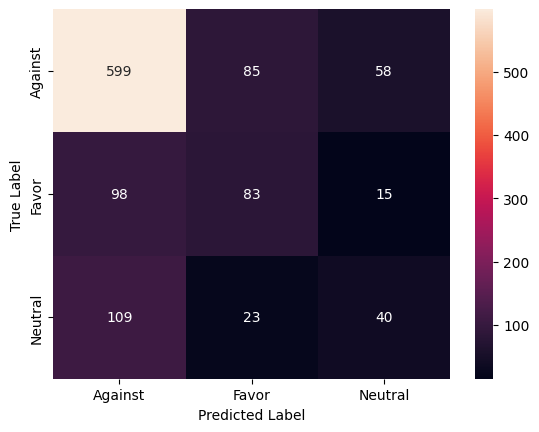

In [54]:

 
def compute_cm(dataloader: DataLoader,model) -> tuple[float, float]:
        """
        Args:
            valid_dataloader: the DataLoader to use to evaluate the model.

        Returns:
            avg_valid_loss: the average validation loss over valid_dataloader.
        """
        valid_loss = 0.0
        valid_acc = 0.0
        y_true = []
        y_pred = []
        # When running in inference mode, it is required to have model.eval() AND .no_grad()
        # Among other things, these set dropout to 0 and turn off gradient computation.
        model.eval()
        with torch.no_grad():
            for batch in dataloader:
                sequence_lengths, inputs, labels,pos_tag_ids = batch

                logits = model((sequence_lengths, inputs,pos_tag_ids))
                
                predictions = torch.argmax(logits, dim=1)

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predictions.cpu().numpy())
        cm = confusion_matrix(y_true, y_pred)
                # Assuming cm_main is your confusion matrix and class_labels is a list of class labels
        class_labels = ["Against", "Favor", "Neutral"]  # Example labels, replace with your actual class labels

        # Plot the heatmap with labels on the axes
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)

        # Add labels to the axes
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')

        # Show the plot
        plt.show()

compute_cm(test_dataloader,trainer_main.model)


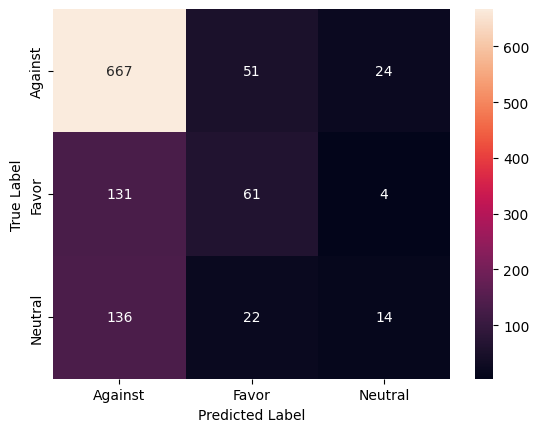

In [55]:
compute_cm(test_dataloader,trainer_simple.model)